In [1]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import rioxarray
import geopandas as gpd
from pyproj import Transformer
import ProcessSERAC
from sklearn.linear_model import LinearRegression
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline


In [2]:
## File directory

SERAC_dir = "/Users/huigao/Desktop/Mass_reconstruction/Annual_thickness_reconstruction/Partition_SERAC2022/"
IS2_dir = "/Users/huigao/Documents/Python_notebooks/202205_ICESat-2_seasonality/Data/"
GrIMP_DEM_dir = '/Volumes/Samsung_T5/Greenland_DEM/NSIDC-0715.002/'

In [3]:
tile_id = 6
SERAC = ProcessSERAC.Read(SERAC_dir+"TimeSeriesTile"+str(tile_id)+"_partitioned.txt", max_col_count = 14)

header, df = SERAC.return_raw()

X = []
Y = []
transformer = Transformer.from_crs("epsg:4326", "epsg:3413", always_xy=True)

for i in range(len(header)):
    x_source = header.iloc[i,10]
    y_source = header.iloc[i,11]
    x, y = transformer.transform(x_source, y_source)
    X.append(x)
    Y.append(y)

header['X'] = X
header['Y'] = Y

header.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,X,Y
0,6000001,12,0,856134.21,7792839.79,1827.438,895.62,1.296,1.045,83020.0,-29.639932,69.996025,56.273100,-9223372036854775808,579664.776251,-2.110203e+06
1,6000006,38,0,538995.39,7700475.85,3044.616,4977.06,0.087,0.085,83020.0,-38.006373,69.410710,49.073400,-9223372036854775808,274411.529821,-2.236960e+06
2,6000008,33,0,1015853.26,7778996.15,947.344,88.11,1.061,1.049,83020.0,-25.641842,69.609362,58.996000,-9223372036854775808,739691.358127,-2.105374e+06
3,6000018,37,0,964439.41,7744848.36,2163.160,1703.75,0.232,0.228,83020.0,-27.104913,69.404938,59.919199,-9223372036854775808,692712.532949,-2.145308e+06
4,6000020,33,0,516611.54,7740277.67,3046.801,6049.86,0.050,0.049,83020.0,-38.569554,69.769952,47.841001,-9223372036854775808,247916.663969,-2.199674e+06


EPSG:3413


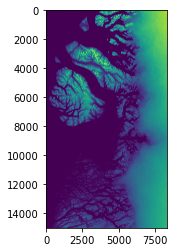

In [4]:
## Only read tile 1.2 near the study area: https://nsidc.org/sites/default/files/nsidc-0715-v002-userguide.pdf
DEM = rasterio.open(GrIMP_DEM_dir+'tile_1_2_30m_dem_v02.0.tif')
print(DEM.crs)


x_DEM_array = DEM.bounds.left + DEM.res[1]/2 + np.arange(0, DEM.width, 1) * DEM.res[1]
y_DEM_array = DEM.bounds.top - DEM.res[0]/2 - np.arange(0, DEM.height, 1) * DEM.res[0]
DEM_array = DEM.read(1)

plt.imshow(DEM_array)

In [5]:
# Read in the ATL14&15 data
atl15 = xr.open_dataset(IS2_dir +"ATL15_GL_0311_01km_001_01.nc", group="delta_h")

In [6]:
# Buffer selected SERAC reconstructions with a distance (buffer_dis) and extract bounding box
def buffer_points(pts, buffer_dis):
    aoi_bound_x = [min(pts[:,0])-buffer_dis, max(pts[:,0])+buffer_dis]
    aoi_bound_y = [min(pts[:,1])-buffer_dis, max(pts[:,1])+buffer_dis]
    return aoi_bound_x, aoi_bound_y

# Crop ATL raster product using the bounding box
def crop_atl_raster(atl_h, pts, buffer_dis):
    aoi_bound_x, aoi_bound_y = buffer_points(pts, buffer_dis)
    atl_h = atl_h.rio.write_crs("EPSG:3413", inplace=True)
    atl_h = atl_h.rio.clip_box(
        minx=aoi_bound_x[0],
        miny=aoi_bound_y[0],
        maxx=aoi_bound_x[1],
        maxy=aoi_bound_y[1]
    )
    return atl_h

In [7]:
buffer_dis = 20000 # Buffer distance (m)

# Define default locations for extracting time series
pts_loc = np.array([[-199638, -2169482],
                   [-188005, -2177025],
                   [-200909, -2187151],
                   [-197017, -2199723]])

use_default = False

if not use_default:
    SERAC_id = header.iloc[:,0].values
    id_input_list = input('Enter the SERAC ID (seperate by space if entering multiple IDs): ')
    buffering = input('Enter the buffering distance (m) for selection of time series (leave this empty if only want to use the IDs provided): ')

    if buffering:
        buffer_dis = int(buffering)
        
    id_input_list = id_input_list.split()

    header_sel = pd.DataFrame()
    id_valid = []
    for id_input in id_input_list:  
        if id_input not in SERAC_id:
            print(id_input+' does not exist and is removed.')
        else:
            id_valid.append(id_input)
            header_sel = pd.concat([header_sel, header[header.iloc[:, 0] == id_input]])

    if id_valid:
        header_sel = header_sel.reset_index(drop = True)
        pts_loc = np.array([header_sel['X'].values, header_sel['Y'].values]).T
    else:
        print('None of the IDs provided exist, will use the default locations.')
        use_default = True
        
if use_default or buffering:
    aoi_bound_x, aoi_bound_y = buffer_points(pts_loc, buffer_dis)
    x_sel = (header['X'].values > aoi_bound_x[0]) & (header['X'].values < aoi_bound_x[1])
    y_sel = (header['Y'].values > aoi_bound_y[0]) & (header['Y'].values < aoi_bound_y[1])

    pts_sel_SERAC = np.logical_and(x_sel, y_sel)
    header_sel = header[pts_sel_SERAC].reset_index(drop = True)

Enter the SERAC ID (seperate by space if entering multiple IDs): 
Enter the buffering distance (m) for selection of time series (leave this empty if only want to use the IDs provided): 
None of the IDs provided exist, will use the default locations.


In [8]:
## Extract time series

# atl14_h_aoi = crop_atl_raster(atl14[['h']], pts_loc, buffer_dis)
atl15_h_aoi = crop_atl_raster(atl15[['delta_h']], pts_loc, buffer_dis)
atl15_herr_aoi = crop_atl_raster(atl15[['delta_h_sigma']], pts_loc, buffer_dis)

h_atl15 = []
herr_atl15 = []
x_err = []
y_err = []

time_SERAC = []
err_ele_SERAC = []
absh_SERAC = []
dynh_SERAC = []

h_DEM = []
x_err_DEM = []
y_err_DEM = []

# Find the position of the k nearest elements in a 1d array to a value
def find_nearest(array, value, k):
    array = np.asarray(array)
    idx = np.argpartition(np.abs(array - value), tuple(range(0,k)))
    return idx[:k]

for i in range(len(header_sel)):
    x_SERAC = header_sel['X'][i]
    y_SERAC = header_sel['Y'][i]
    ind_x_atl15 = find_nearest(atl15['x'].values, x_SERAC, 1).item()
    ind_y_atl15 = find_nearest(atl15['y'].values, y_SERAC, 1).item()
    x_err.append(atl15['x'].values[ind_x_atl15] - x_SERAC)
    y_err.append(atl15['y'].values[ind_y_atl15] - y_SERAC)
    
    ts_atl15_h = atl15_h_aoi.sel(x=x_SERAC, y=y_SERAC, method="nearest")
    ts_atl15_herr = atl15_herr_aoi.sel(x=x_SERAC, y=y_SERAC, method="nearest")
    
    h_atl15.append(ts_atl15_h['delta_h'].values)
    herr_atl15.append(ts_atl15_herr['delta_h_sigma'].values)
    
    
    ind_x_DEM = find_nearest(x_DEM_array, x_SERAC, 1).item()
    ind_y_DEM = find_nearest(y_DEM_array, y_SERAC, 1).item()
    x_err_DEM.append(x_DEM_array[ind_x_DEM] - x_SERAC)
    y_err_DEM.append(y_DEM_array[ind_y_DEM] - y_SERAC)
   
    h_DEM.append(DEM_array[ind_y_DEM, ind_x_DEM])

    
    SERAC_id = header_sel.iloc[i, 0]
    time_SERAC.append(df[SERAC_id][1].values)
    err_ele_SERAC.append(df[SERAC_id][5].values)
    absh_SERAC.append(df[SERAC_id][6].values)
    dynh_SERAC.append(df[SERAC_id][11].values)

SERAC_atl15_dis = np.sqrt(np.array(x_err)**2 + np.array(y_err)**2)
# print("Distance between SERAC time series and closest ATL15 product (m): \n", SERAC_atl15_dis)    


# Get SERAC elevation on Jan 1, 2020, linear interpolation or 0
SERAC_2020 = []
for i in range(len(absh_SERAC)):
    ind_2020 = find_nearest(time_SERAC[i], 2020, 5)
    time_S2020 = time_SERAC[i][ind_2020]
    before_2020 = np.where((time_S2020 - 2020) < 0)[0]
    after_2020 = np.where((time_S2020 - 2020) > 0)[0]

    if 0 not in (before_2020.size, after_2020.size):
        ind_2 = [before_2020[0], after_2020[0]]
        time_S2020 = time_S2020[ind_2]
        if np.all(abs(time_S2020 - 2020)<0.5):
            y = absh_SERAC[i][ind_2020[ind_2]]
            model = LinearRegression().fit(time_S2020.reshape((-1, 1)), y)
            SERAC_2020_1pts = model.predict(np.array([[2020]])).item()
        else:
            SERAC_2020_1pts = 0
    else:
        SERAC_2020_1pts = 0
    SERAC_2020.append(SERAC_2020_1pts)
SERAC_2020 = np.array(SERAC_2020)

# Datetime to decimal year
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

time_atl15 = []
for time in atl15_h_aoi['time'].values:
    time_atl15.append(year_fraction(pd.Timestamp(time).to_pydatetime()))

/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


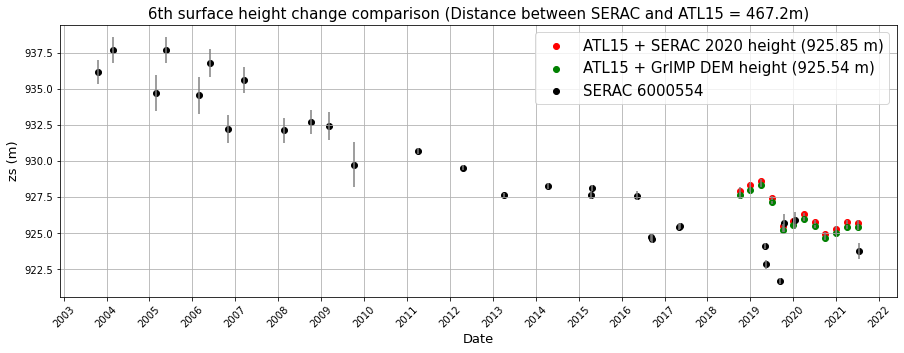

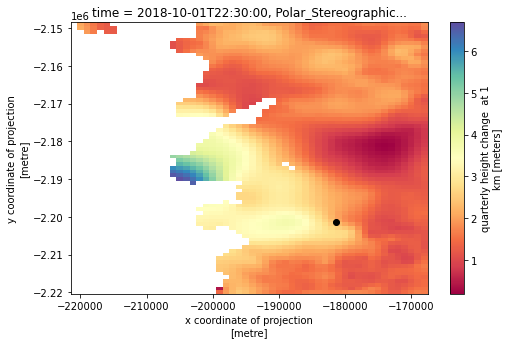

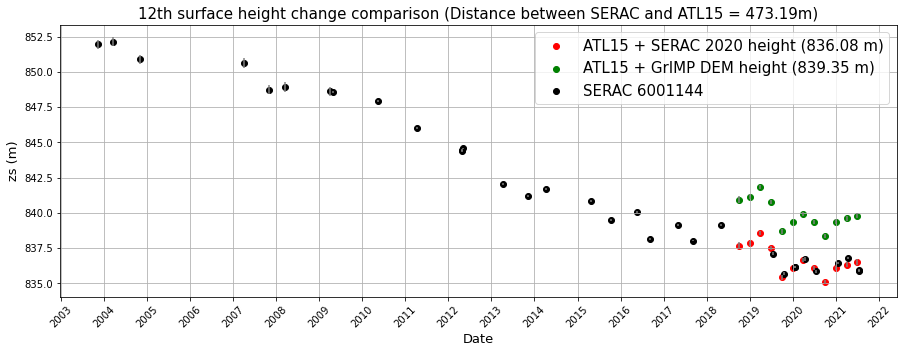

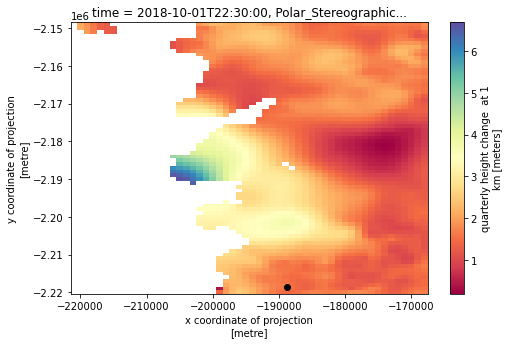

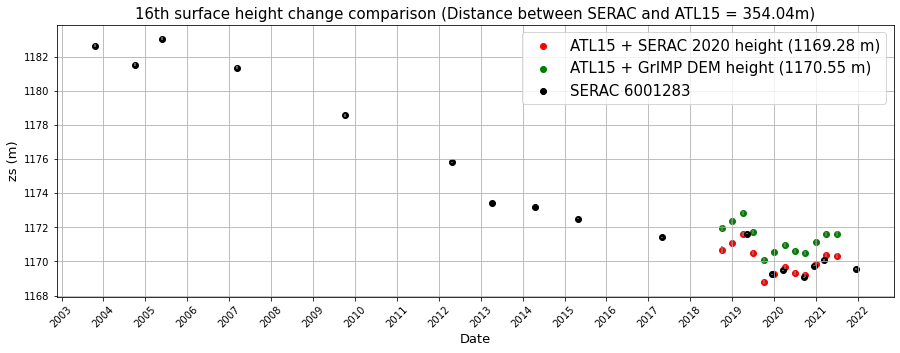

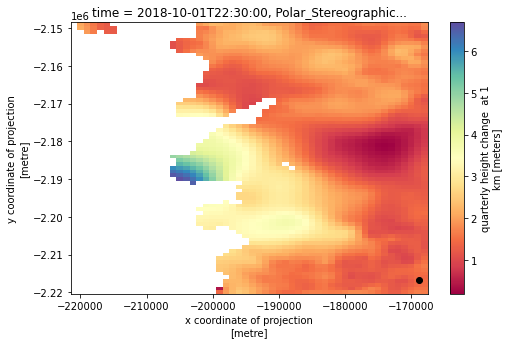

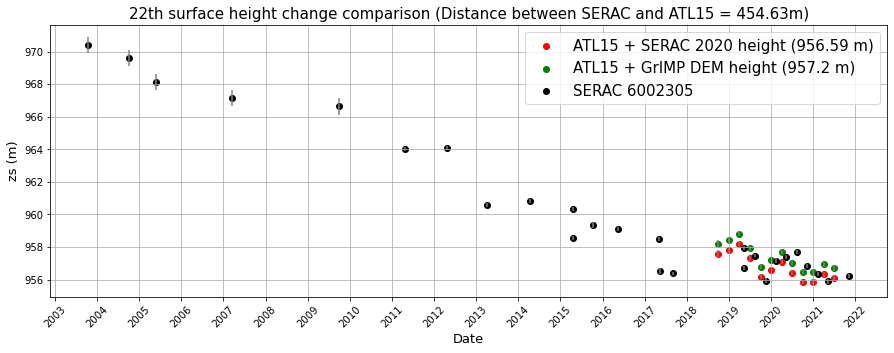

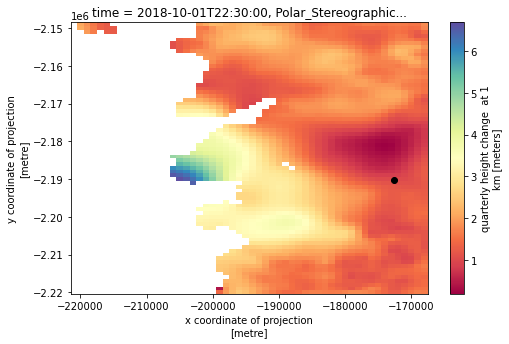

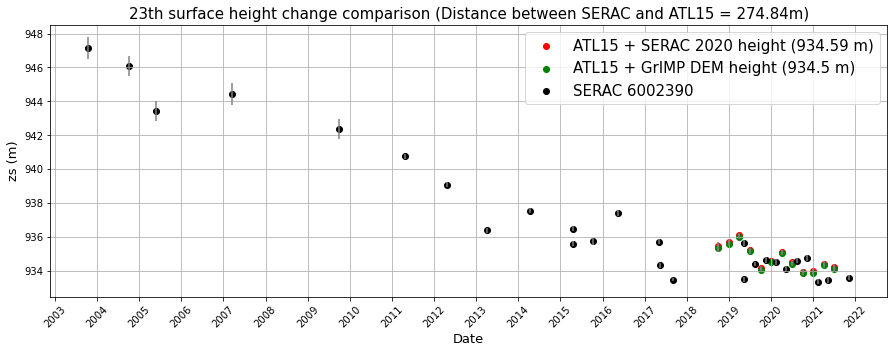

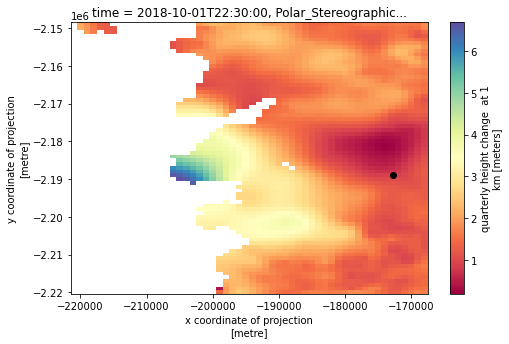

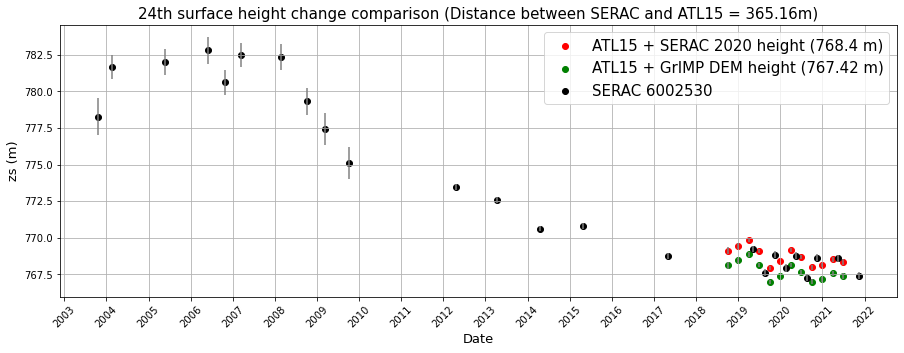

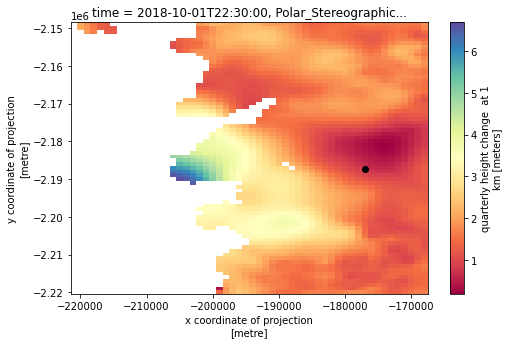

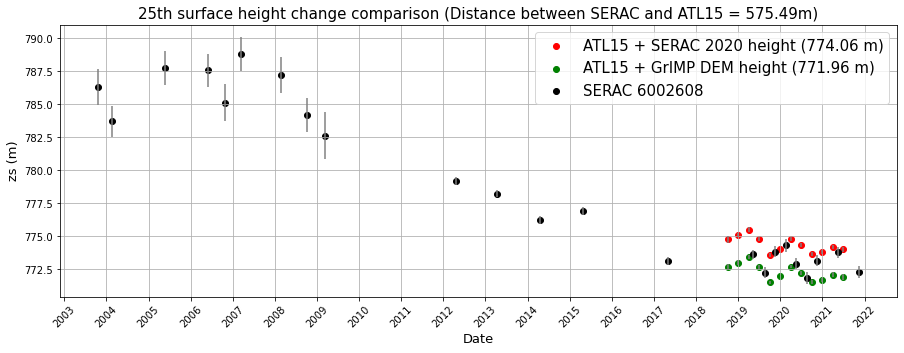

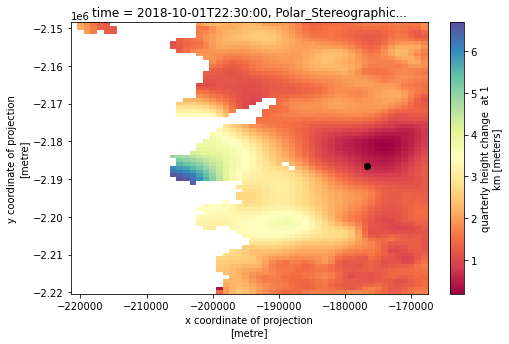

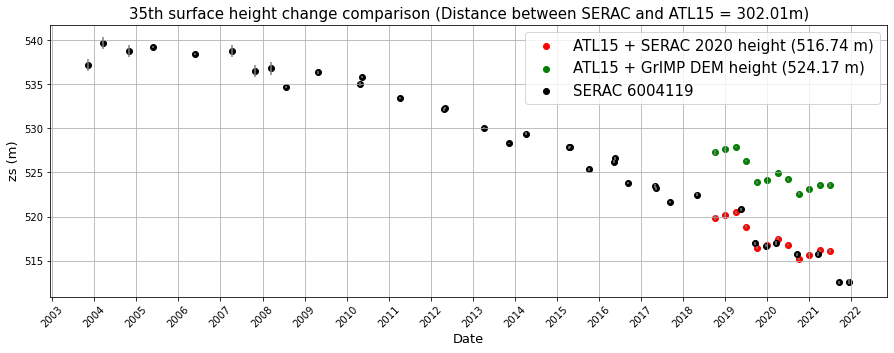

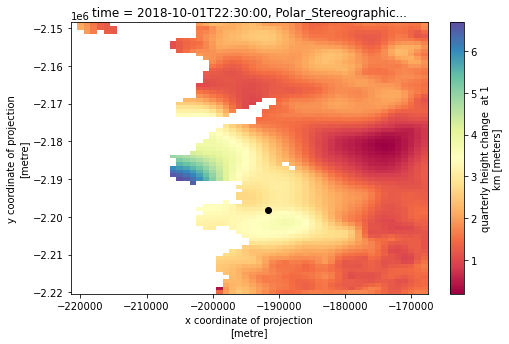

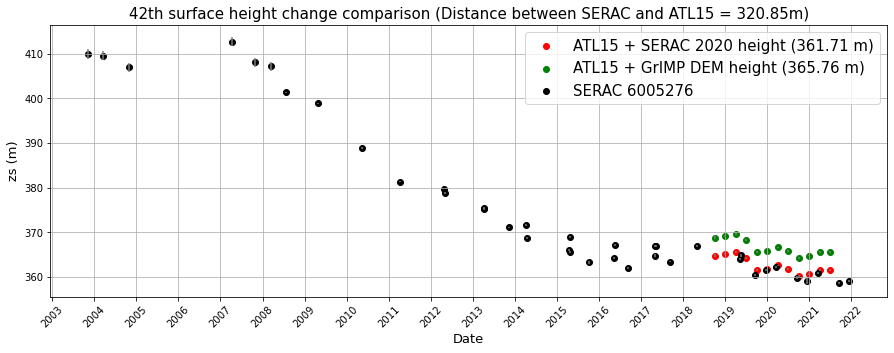

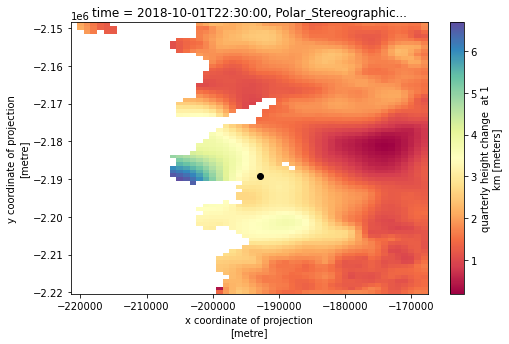

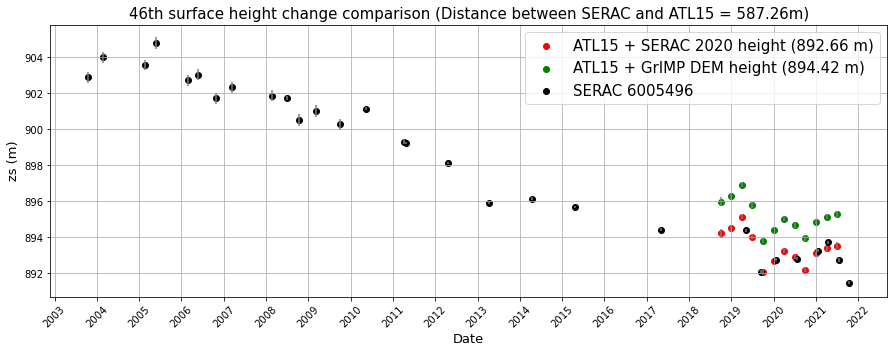

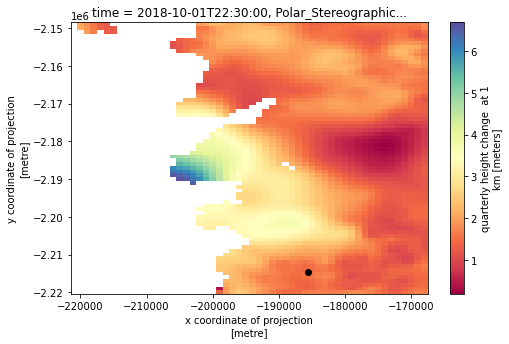

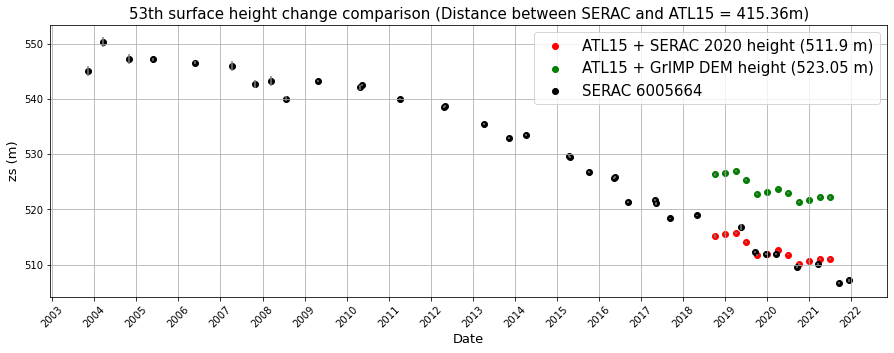

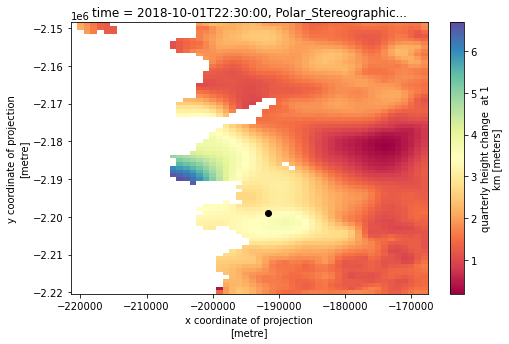

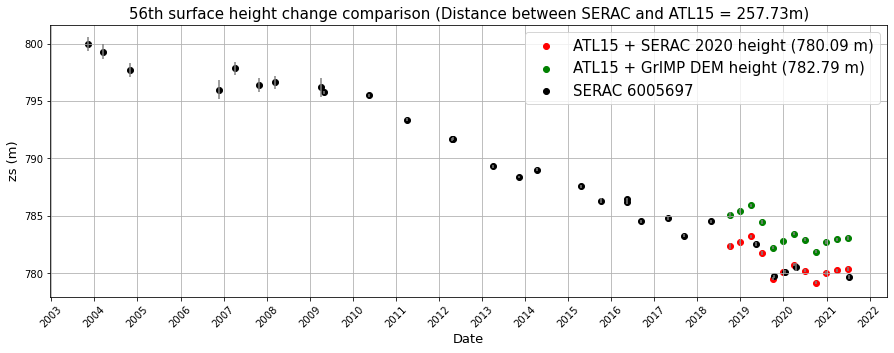

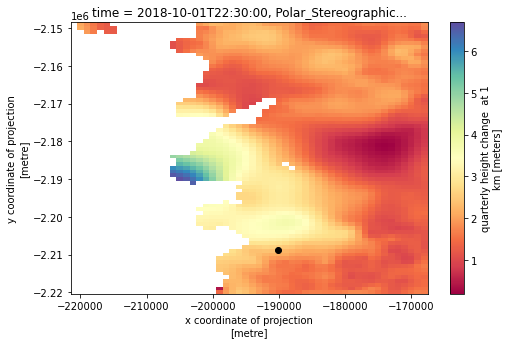

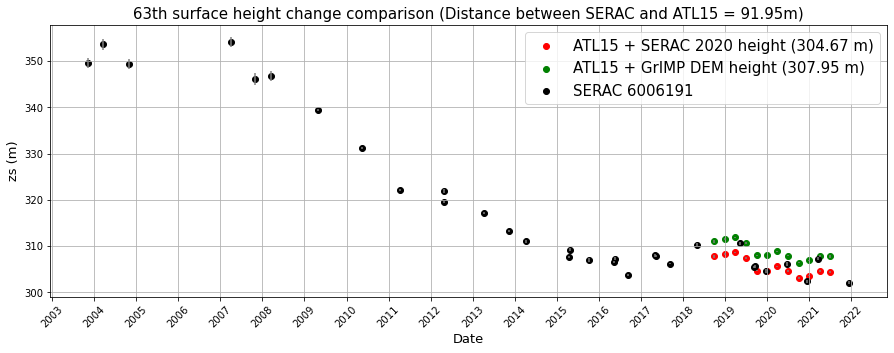

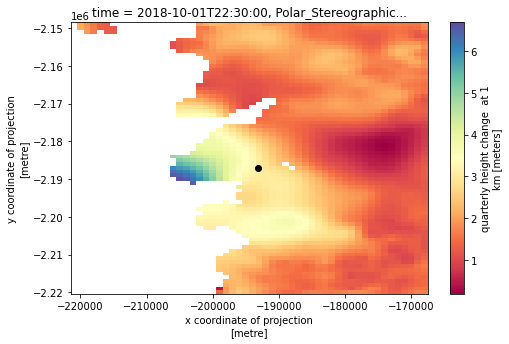

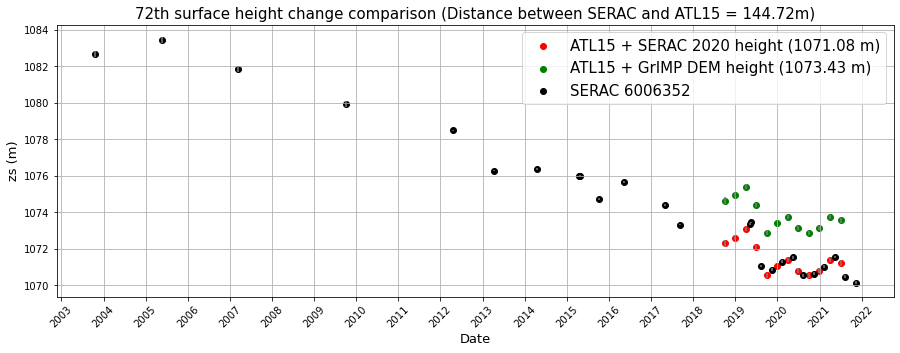

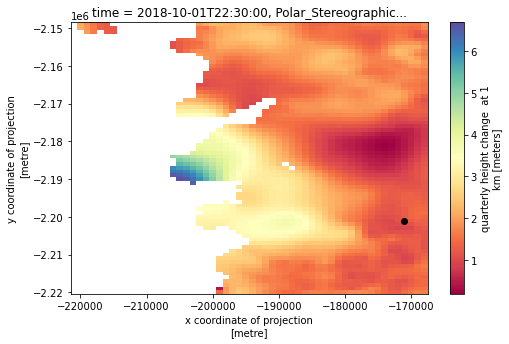

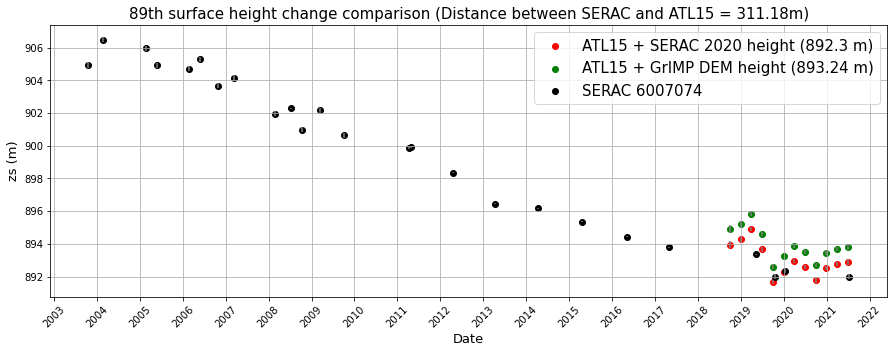

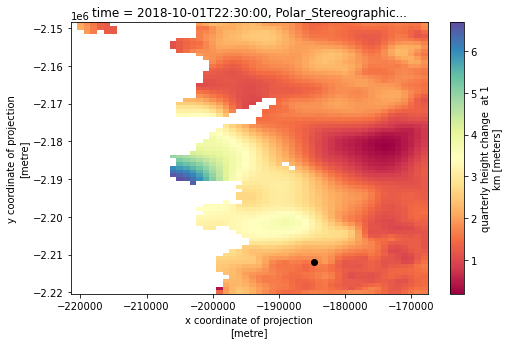

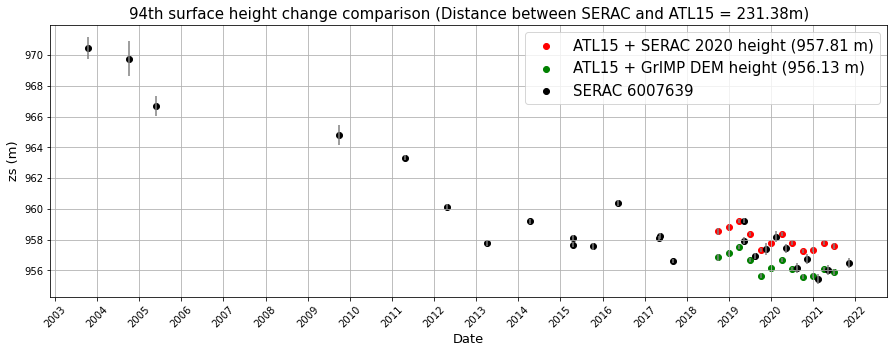

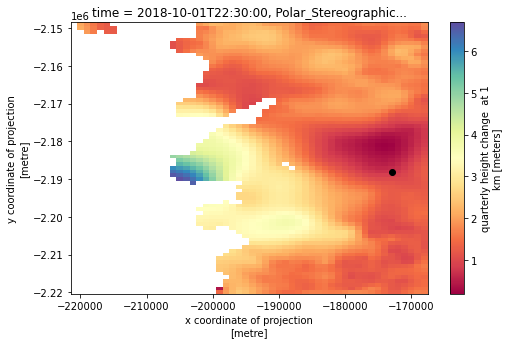

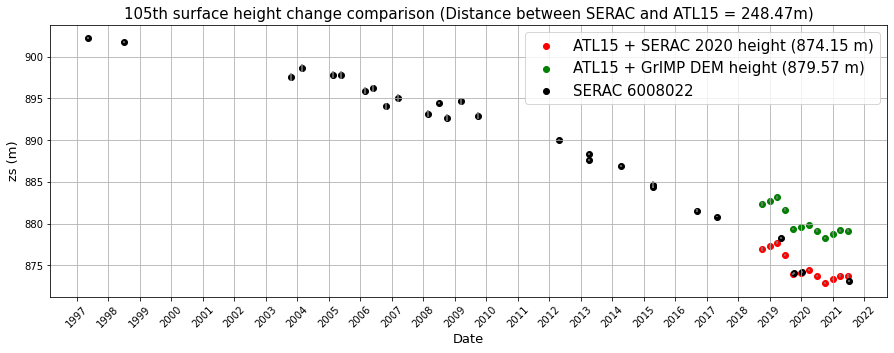

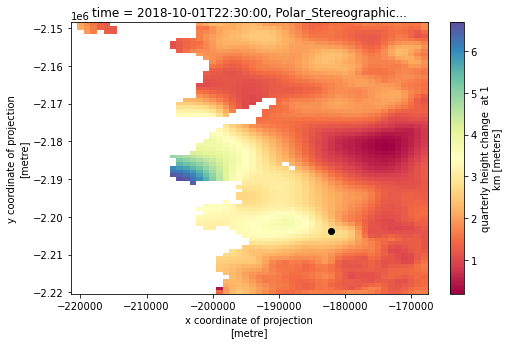

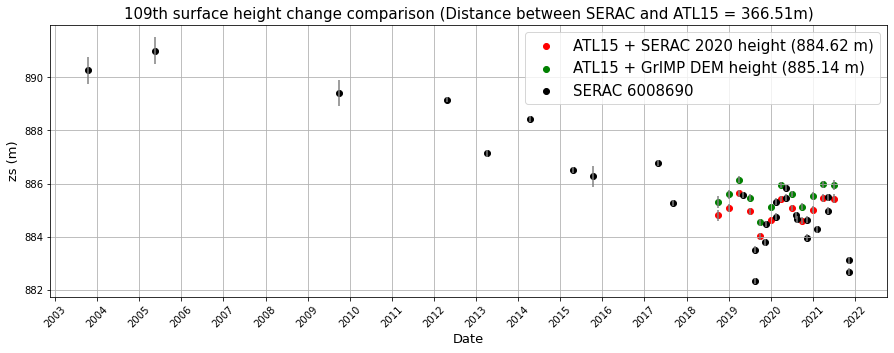

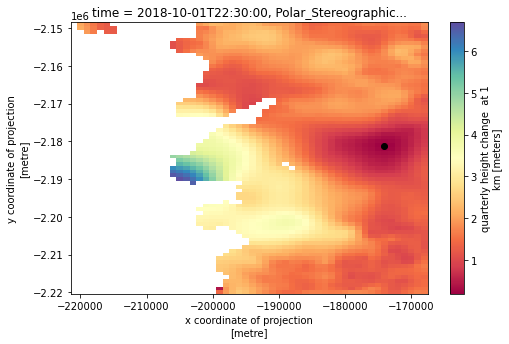

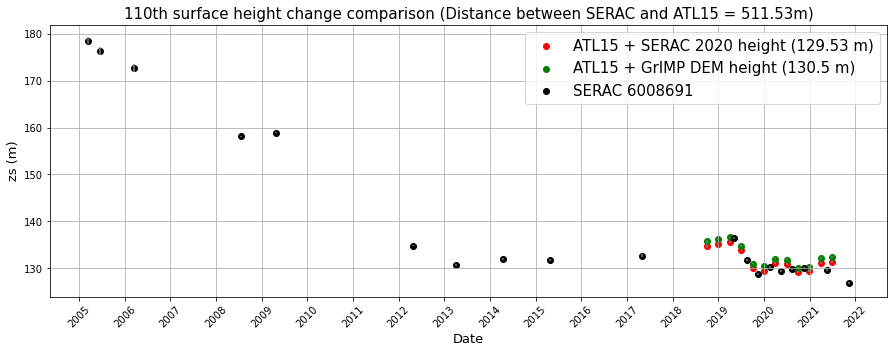

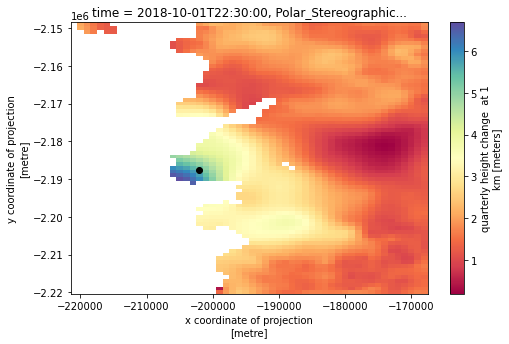

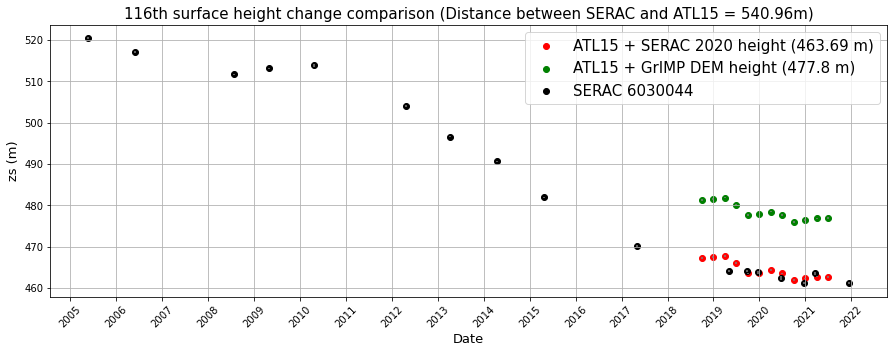

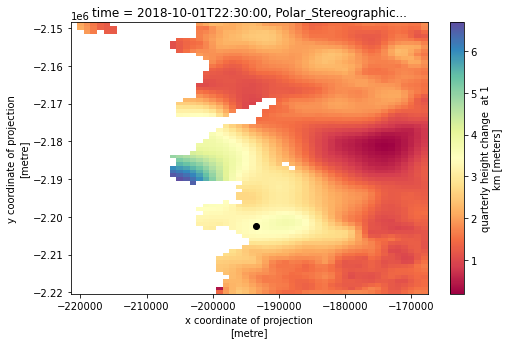

In [9]:
## Plot 

rand_plot = True
normalized = True

normalized_ind = np.where(SERAC_2020 > 0)[0]
if normalized:
    inds = normalized_ind
else:
    inds = range(len(absh_SERAC))

k = 20 
if len(inds)>k:
    if rand_plot:
        examp_plot_id = np.sort(np.random.permutation(inds)[:k])
    else:
        examp_plot_id = inds[:k]
else:
    examp_plot_id = inds


for i in examp_plot_id:
    fig, ax = plt.subplots(figsize = (15,5))
    ax.scatter(time_atl15, h_atl15[i]+SERAC_2020[i], c = 'r', label = 'ATL15 + SERAC 2020 height ('+str(np.round(SERAC_2020[i], 2)) +' m)')
    plt.errorbar(time_atl15, h_atl15[i]+SERAC_2020[i], yerr = herr_atl15[i], color='grey', linestyle='')
    
    ax.scatter(time_atl15, h_atl15[i]+h_DEM[i], c = 'g', label = 'ATL15 + GrIMP DEM height ('+str(np.round(h_DEM[i], 2)) +' m)')
    plt.errorbar(time_atl15, h_atl15[i]+h_DEM[i], yerr = herr_atl15[i], color='grey', linestyle='')
    
    msk_SERAC = time_SERAC[i]>1990
    time_msked = time_SERAC[i][msk_SERAC]
    ax.scatter(time_msked, absh_SERAC[i][msk_SERAC], c = 'k', label = 'SERAC '+header_sel.iloc[i, 0])
    plt.errorbar(time_msked, absh_SERAC[i][msk_SERAC], yerr = err_ele_SERAC[i][msk_SERAC], color='grey', linestyle='')
    
    ax.set_xticks(np.arange(int(time_msked[0]), 2023, 1))
    ax.set_xlabel('Date',fontsize = 13)
    ax.set_ylabel('zs (m)', fontsize=13)
    ax.set_title(str(i)+'th surface height change comparison (Distance between SERAC and ATL15 = '+str(np.round(SERAC_atl15_dis[i],2))+'m)', fontsize=15)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=15)
    ax.grid(True)
    
    fig = plt.subplots(figsize = (8,5))
    atl15_h_aoi.delta_h[0].plot(cmap="Spectral") # , vmin=-100, vmax=2000
    plt.scatter(header_sel['X'].values[i], header_sel['Y'].values[i], c = 'k')
    plt.show()

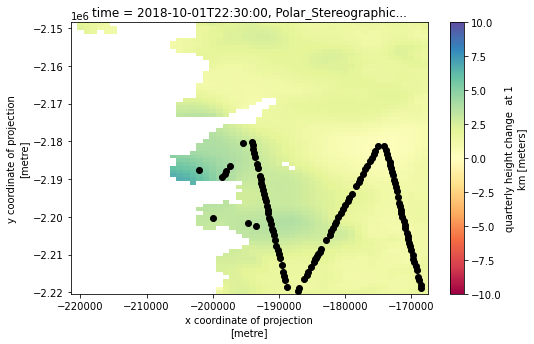

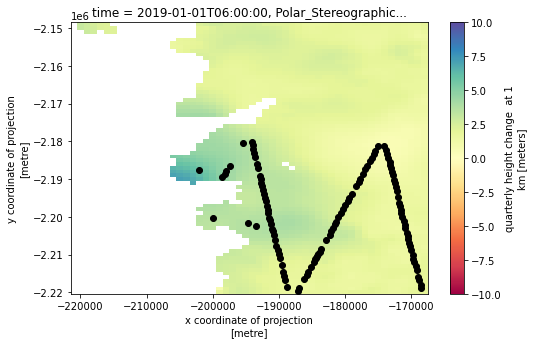

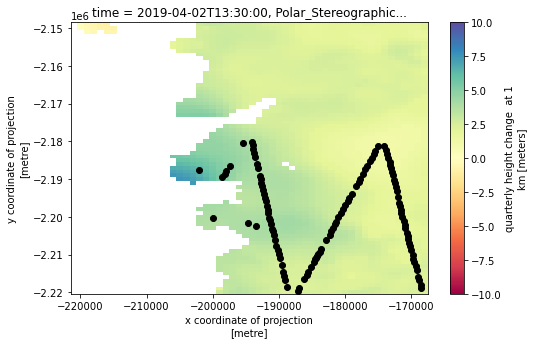

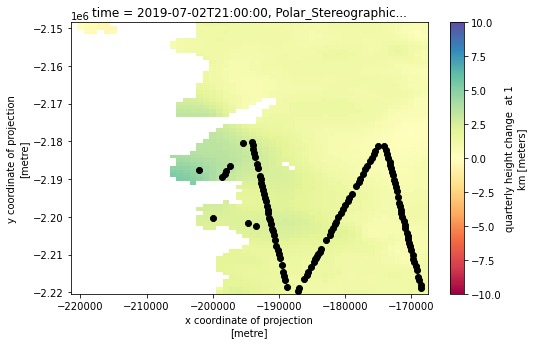

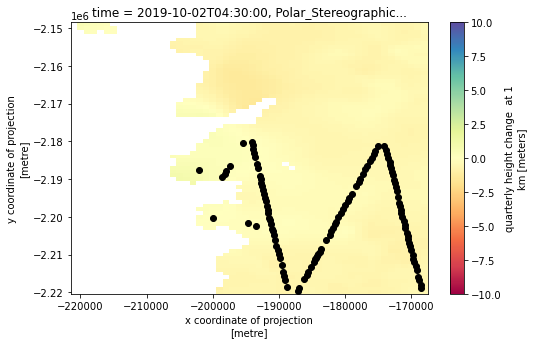

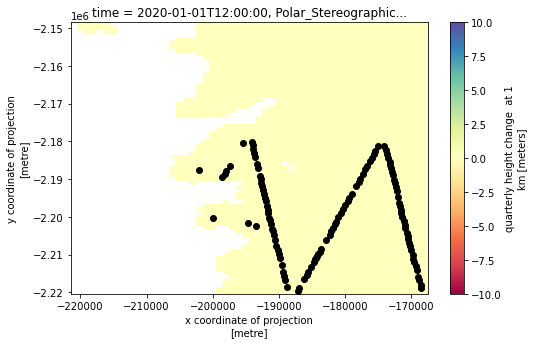

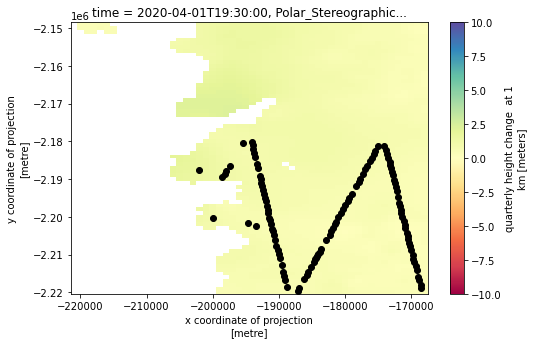

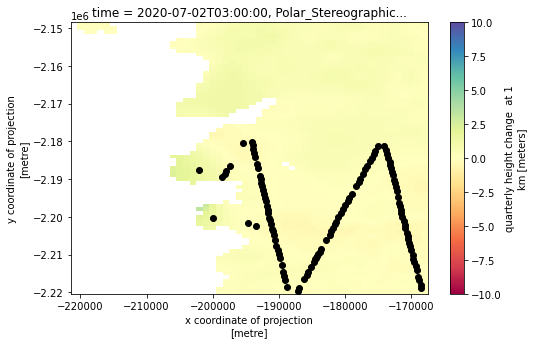

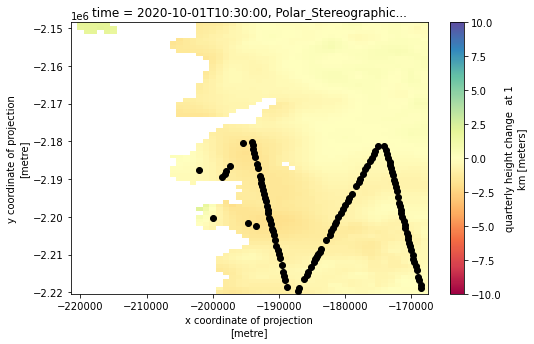

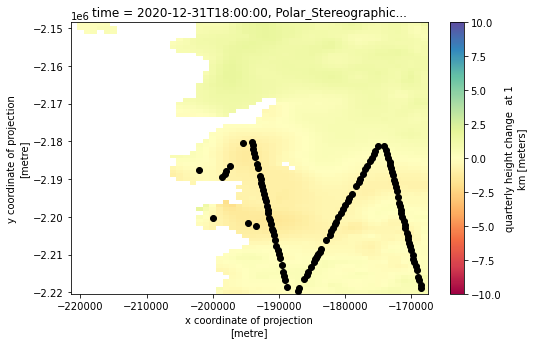

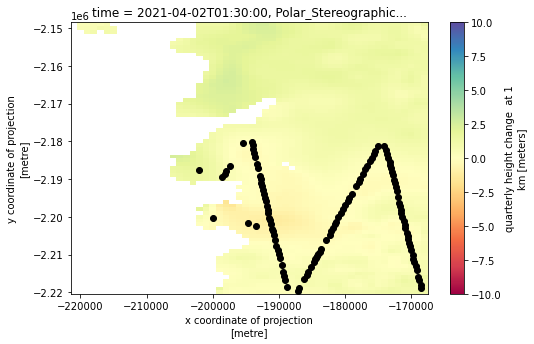

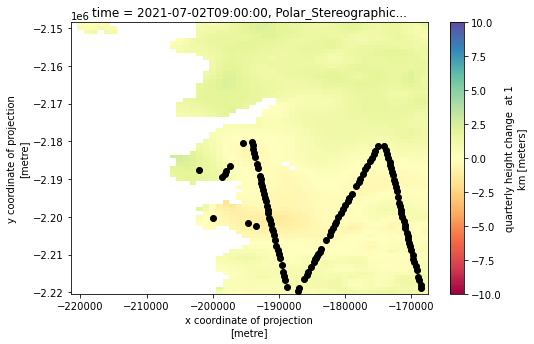

In [13]:
for i in range(len(atl15_h_aoi['time'])):
    fig = plt.subplots(figsize = (8,5))
    fig_atl15 = atl15_h_aoi.delta_h[i,:,:].plot(cmap="Spectral")
    fig_atl15.set_clim(vmin=-10, vmax=10)

    plt.scatter(header_sel['X'].values, header_sel['Y'].values, c = 'k')
    plt.show()